# Random Forest

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import os
from sklearn.metrics import make_scorer
from random import randint

In [2]:
# external imports
%run ../common/utilities.ipynb

**Load Pickled Files**

In [3]:
X_train = load_object("../input_data/", "X_train")
y_train = load_object("../input_data/", "y_train")
X_val = load_object("../input_data/", "X_val")
y_val = load_object("../input_data/", "y_val")
X_test = load_object("../input_data/", "X_test")
y_test = load_object("../input_data/", "y_test")

In [4]:
pd.DataFrame(y_val).value_counts()/len(y_val)*100

0    97.92176
1     2.07824
dtype: float64

In [5]:
pd.DataFrame(y_test).value_counts()/len(y_test)*100

0    97.861943
1     2.138057
dtype: float64

In [6]:
X_smote, y_smote = perform_smote(X_train, y_train, 0.05)

In [7]:
np.unique(X_smote)

array([0, 1], dtype=uint8)

In [8]:
np.unique(y_smote)

array([0, 1], dtype=int64)

In [9]:
len(X_train)

4908

In [10]:
len(X_smote)

5044

In [11]:
len(y_train)

4908

In [12]:
len(y_smote)

5044

### Get Predefined Split Cross Validator

In [13]:
X_train_val, y_train_val, ps_original = get_train_val_ps(X_smote, y_smote, X_val, y_val)

### Modelling

In [14]:
# Make directory
directory = os.path.dirname('./metric_logs/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [15]:
models = {'random_forest': RandomForestClassifier(class_weight='balanced', random_state=42)}

In [16]:
pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

In [17]:
param_grids = {}

# The grids for min_samples_split
min_samples_split_grids = [2,5, 10, 15, 20, 30, 50, 80, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 2, 5, 10, 15, 20, 30, 50, 80, 100]

# Update param_grids
param_grids['random_forest'] = [{'model__min_samples_split': min_samples_split_grids,
                                 'model__min_samples_leaf': min_samples_leaf_grids}]

## Compute F2 score for Validation:

In [18]:
# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_params_estimator_gs = []

# For each model
for acronym in pipes.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring=make_scorer(f2_measure),
                      n_jobs=-1,
                      cv=ps_original,
                      return_train_score=True)
        
    # Fit the pipeline
    gs = gs.fit(X_train_val, y_train_val)
    
    # Update best_score_params_estimator_gs
    best_score_params_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write cv_results file
    cv_results.to_csv(path_or_buf=directory +"/"+ acronym + '.csv', index=False)

# Sort best_score_params_estimator_gs in descending order of the best_score_
best_score_params_estimator_gs = sorted(best_score_params_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_params_estimator_gs
pd.DataFrame(best_score_params_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

,best_score,best_param,best_estimator
0,0.416667,"{'model__min_samples_leaf': 5, 'model__min_sam...","((DecisionTreeClassifier(max_features='auto', ..."


In [19]:
# Get the best_score, best_params and best_estimator obtained by GridSearchCV
best_score_gs, best_params_gs, best_estimator_gs = best_score_params_estimator_gs[0]

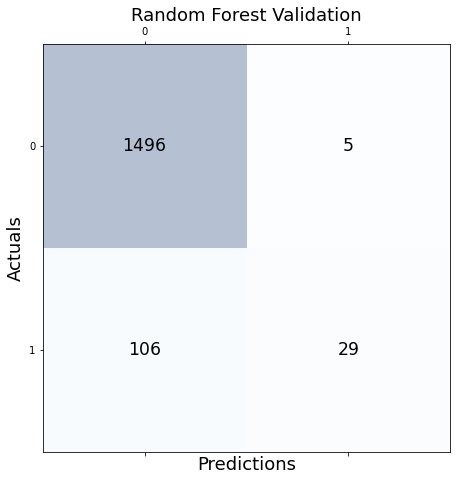

In [20]:
confusion_matrix_plotter(best_estimator_gs.predict(X_val), y_val, "Random Forest Validation")

## Compute F2 score for Test:

In [21]:
# Get the prediction on the testing data using best_model
y_test_pred = best_estimator_gs.predict(X_test)

# Get the f2 score
f2_score = f2_measure(y_test, y_test_pred)

pd.DataFrame([{"F2 Score":f2_score}])

,F2 Score
0,0.407801


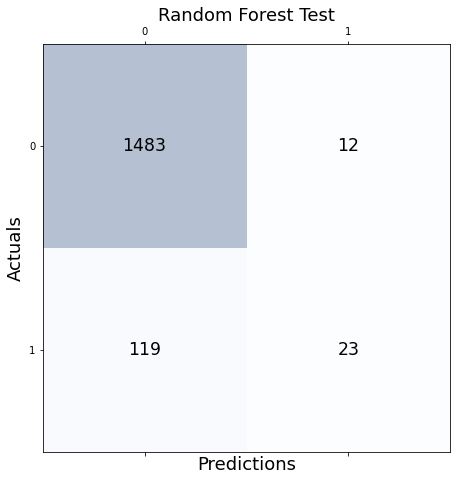

In [22]:
confusion_matrix_plotter(best_estimator_gs.predict(X_test), y_test, "Random Forest Test")

In [23]:
# save best model
save_object("./best_saved_models/", "random_forest", best_estimator_gs)